# 数据交易沙箱 - 演示案例

数据交易沙箱通过对敏感数据发现、数据抽样等方式，将数据从运行环境经过抽样之后上送到调试环境中，数据分析师在只能看到抽样数据的前提下，进行数据分析和建模操作。

In [ ]:
# 导入数据集 insurance-s-train-sample
 
import wfio
_INPUT = '{"type":15,"uri":"awss32d9f105f22ab411298cdd6462cc2ee1d/sd_5629997fec4649668cd83bbd83aa03ba"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df = wfio.read_dataframe(_INPUT,as_spark = False)

## 案例背景

我们的演示数据来自一家知名保险公司及其合作的医疗机构，保险公司希望通过建立机器学习模型，评估当年已经购买人寿保险的客户在次年续保的意愿。

过去的人寿保险的推销需要逐个向客户进行推销，在不清楚客户的续保意愿流程繁琐且战线长，大大降低了保险公司的营销效率，增加了营销成本。

该问题预测的标签为：用户对当前保险方案的满意度。

由不满意到满意共有8个标签，1代表非常不满意，从1 开始满意度逐渐增加，8代表非常满意。

该案例中，保险公司用于评价模型的评价指标为“Quadratic_Weighted_Kappa”（次加权Kappa），该指标通常落在 0 ～ 1 之间，越大效果越好。

## 分析开始

数据分析师首先从数据交易沙箱导入抽样数据，然后再进行必要的数据探索。

In [1]:
#导入必要的包

#计算与可视化
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#评估指标、编码与模型
from  sklearn.metrics import accuracy_score,  auc, confusion_matrix, roc_auc_score, classification_report,cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.optimize import fmin_powell
#from ml_metrics import quadratic_weighted_kappa
from wf_analyse.analyse import base

In [2]:
# 导入数据集 insurance_train_with_sensitive
 
import wfio
_INPUT = '{"type":15,"uri":"awss32d9f105f22ab411298cdd6462cc2ee1d/sd_5629997fec4649668cd83bbd83aa03ba"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
train = wfio.read_dataframe(_INPUT,as_spark = False)

In [3]:
# 导入数据集 insurance_test_with_sensitive
 
import wfio
_INPUT2 =  '{"type":15,"uri":"awss3bbbfe5c8f0704f05b61aa304dde4ae74/sd_2de4c41af9b24ea3969f0a9537af7386"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
test = wfio.read_dataframe(_INPUT,as_spark = False)

In [4]:
train.head()

,empty_name,name,sex,id_card,mobile_number,email,addr,product_info_1,product_info_2,product_info_3,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
0,0,孙*,女,**************173X,1721258****,NaN,福建省莆********-**-*****,1,D4,26,...,0,0,0,0,0,0,0,0,0,6
1,2,陆昌*,男,**************3850,1827906****,NaN,广东省梅*********-**-****,1,A8,10,...,1,0,0,0,0,0,0,0,0,1
2,3,陈*,男,**************3750,1327455****,NaN,广东省珠**********-**-***,2,D4,26,...,0,0,0,0,0,0,0,0,0,8
3,4,周凡*,女,**************1925,1523119****,NaN,广东省揭**********-*-****,1,D3,26,...,0,0,0,0,0,0,0,0,0,6
4,5,李*,女,**************5522,1714197****,NaN,浙江省*********-*-***-**,1,D2,26,...,0,0,0,0,0,0,0,0,0,3


In [5]:
train.drop("empty_name", axis = 1,inplace=True)
test.drop("empty_name", axis = 1, inplace=True)

## 分析
**1.用户的姓名、身份证号码，手机号以及家庭住址地址进行了敏感处理**<p>
    其中身份证的后四位包含性别信息，可用于与sex性别字段进行一致性检验<p>
    addr里含有省份信息，该信息可用于产生新的字段”province“<p>
    其他敏感信息不可用<p>
**2.email直接置为空**

# 查看数据

## 查看数据的维度、数据类型等信息

In [6]:
test.shape

(4157, 133)

In [7]:
#查看训练集数据
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Columns: 133 entries, name to response
dtypes: float64(19), int64(108), object(6)
memory usage: 4.2+ MB
None


,name,sex,id_card,mobile_number,email,addr,product_info_1,product_info_2,product_info_3,product_info_4,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
0,孙*,女,**************173X,1721258****,NaN,福建省莆********-**-*****,1,D4,26,0.743590,...,0,0,0,0,0,0,0,0,0,6
1,陆昌*,男,**************3850,1827906****,NaN,广东省梅*********-**-****,1,A8,10,0.076923,...,1,0,0,0,0,0,0,0,0,1
2,陈*,男,**************3750,1327455****,NaN,广东省珠**********-**-***,2,D4,26,0.487179,...,0,0,0,0,0,0,0,0,0,8
3,周凡*,女,**************1925,1523119****,NaN,广东省揭**********-*-****,1,D3,26,0.641026,...,0,0,0,0,0,0,0,0,0,6
4,李*,女,**************5522,1714197****,NaN,浙江省*********-*-***-**,1,D2,26,0.076923,...,0,0,0,0,0,0,0,0,0,3


## 数据集解析
### 总体说明：
该训练集的抽样数据一共有**4157**条样本， 每条样本有**127**个字段特征。其中，有18个`float64`类型的字段, 108个`int64`类型的字段,1个 `object`类型的字段。

### 字段含义说明：
* Ins_Age：客户年龄（标准化处理过的结果）
* Ht：客户身高（标准化处理过的结果）
* Wt：客户体重（标准化处理过的结果）
* BMI：客户身体健康指数（标准化处理过的结果）
* Product_Info_1-7：客户产品相关的变量（处理后的结果）
* Employment_Info_1-6：有关客户工作经验的变量（处理后的结果）
* InsuredInfo_1-6：有关客户的信息变量（处理后的结果）
* Insurance_History_1-9：有关客户过去的保险信息（处理后的结果）
* Family_Hist_1-5:有关客户家庭相关的信息（处理后的结果）
* Medical_History_1-41：有关客户的医疗史信息（处理后的结果）
* Medical_Keyword_1-48：与该保险相关或不相关的医疗信息？？？不太确定含义，该信息是伪变量
* Response：响应值（1-8级：1，2，3，4，5，6，7，8）(本任务的目标变量)

### 字段类型说明：
* 连续值变量：
<p> Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5.<p> 

* 离散值变量：
<p> Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32
Medical_Keyword_1-48 are dummy variables.<p> 

* 无序的类别变量：
<p> Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41



In [8]:
##找出object类型的特征
#for f in train.columns:
#    if train[f].dtype == 'object':
#        print(f+'\n')
#        print(train[f].unique())
#        print(len(train[f].unique()))

**数据集中唯一的`object`类型特征是`Product_Info_2`**，该特征共19个取值，字符串形式是**字母+数字**

##  缺失值分析

在正式的建模之前，数据分析师通常会通过基本的分析进行

In [9]:
#缺失值分析函数
def missing_data(df):
    #缺失值个数统计
    all_null = df.isnull().sum()
    
    #缺失值百分比统计
    percent = df.isnull().mean()*100
    
    #合并缺失值个数与百分比统计
    miss_table = pd.concat([all_null, percent], axis=1, keys=['MissTotalNum', 'MissPercent'])
    
    #添加字段类型
    types = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)
    miss_table['Types'] = types
    return miss_table

In [10]:
#查看训练集缺失值比例
print(missing_data(train)['MissPercent'].sort_values(ascending=False)[:20])
#打印有缺失值的字段
print("存在缺失值的字段：\n")
[train.columns[train.isnull().mean() > 0]]

email                  100.000000
medical_history_10      99.085879
medical_history_32      97.786866
medical_history_24      94.034159
medical_history_15      74.212172
family_hist_5           69.882127
family_hist_3           56.651431
family_hist_2           49.530912
insurance_history_5     43.180178
family_hist_4           33.004571
employment_info_6       17.873466
medical_history_1       14.938658
employment_info_4       11.330286
employment_info_1        0.048112
insurance_history_8      0.000000
insurance_history_9      0.000000
family_hist_1            0.000000
medical_history_21       0.000000
medical_history_20       0.000000
medical_history_19       0.000000
Name: MissPercent, dtype: float64
存在缺失值的字段：



[Index(['email', 'employment_info_1', 'employment_info_4', 'employment_info_6',
        'insurance_history_5', 'family_hist_2', 'family_hist_3',
        'family_hist_4', 'family_hist_5', 'medical_history_1',
        'medical_history_10', 'medical_history_15', 'medical_history_24',
        'medical_history_32'],
       dtype='object')]

In [11]:
#查看测试集缺失值比例
print(missing_data(test)['MissPercent'].sort_values(ascending=False)[:20])

#打印有缺失值的字段
print("存在缺失值的字段：\n")
[test.columns[test.isnull().mean() > 0]]

email                  100.000000
medical_history_10      99.085879
medical_history_32      97.786866
medical_history_24      94.034159
medical_history_15      74.212172
family_hist_5           69.882127
family_hist_3           56.651431
family_hist_2           49.530912
insurance_history_5     43.180178
family_hist_4           33.004571
employment_info_6       17.873466
medical_history_1       14.938658
employment_info_4       11.330286
employment_info_1        0.048112
insurance_history_8      0.000000
insurance_history_9      0.000000
family_hist_1            0.000000
medical_history_21       0.000000
medical_history_20       0.000000
medical_history_19       0.000000
Name: MissPercent, dtype: float64
存在缺失值的字段：



[Index(['email', 'employment_info_1', 'employment_info_4', 'employment_info_6',
        'insurance_history_5', 'family_hist_2', 'family_hist_3',
        'family_hist_4', 'family_hist_5', 'medical_history_1',
        'medical_history_10', 'medical_history_15', 'medical_history_24',
        'medical_history_32'],
       dtype='object')]

### 缺失值探索结果
测试集和训练集缺失值的分布基本一致，也是Medical_History_10 、Medical_History_32 、Medical_History_24 和Medical_History_15四个字段的缺失值百分比高于75%,且存在缺失值的字段也是这10个字段：'Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6','Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3','Family_Hist_4', 'Family_Hist_5', 'Medical_History_1'

**打印具有空值的列名和数据类型**

In [12]:
#进一步查看数值型空值情况
list_train=train.columns[train.isnull().mean() > 0].tolist()
for i in range(0,len(list_train)):
    print('column name: ',list_train[i],' Dtype:',train[list_train[i]].dtypes, 'unique:',train[list_train[i]].unique().shape[0])

column name:  email  Dtype: float64 unique: 1
column name:  employment_info_1  Dtype: float64 unique: 394
column name:  employment_info_4  Dtype: float64 unique: 180
column name:  employment_info_6  Dtype: float64 unique: 242
column name:  insurance_history_5  Dtype: float64 unique: 324
column name:  family_hist_2  Dtype: float64 unique: 61
column name:  family_hist_3  Dtype: float64 unique: 81
column name:  family_hist_4  Dtype: float64 unique: 64
column name:  family_hist_5  Dtype: float64 unique: 79
column name:  medical_history_1  Dtype: float64 unique: 87
column name:  medical_history_10  Dtype: float64 unique: 20
column name:  medical_history_15  Dtype: float64 unique: 209
column name:  medical_history_24  Dtype: float64 unique: 71
column name:  medical_history_32  Dtype: float64 unique: 18


**从结果看，后五个字段特征的取值个数均在164个以内，因此将对这五个特征众数填补空值，其他用均值填补空值。**

In [13]:
#空值处理
for column in list_train:

    if train[column].unique().shape[0] >200: #均值填充
        train[column].fillna(train[column].mean(), inplace=True)
    else:  #众数填充
        train[column].fillna(float(train[column].mean()), inplace=True)  
    
    #else:  #中位数填充
    #   train[columtrain[column].mode()n].fillna(train[column].median(), inplace=True)   
train.isnull().sum().sort_values(ascending=False)

email                 4157
response                 0
family_hist_4            0
medical_history_5        0
medical_history_4        0
                      ... 
medical_keyword_10       0
medical_keyword_11       0
medical_keyword_12       0
medical_keyword_13       0
name                     0
Length: 133, dtype: int64

In [14]:
#测试集数值型空值情况
list_test=test.columns[test.isnull().mean() > 0].tolist()
for i in range(0,len(list_test)):
    print('column name: ',list_test[i],' Dtype:',test[list_test[i]].dtypes, 'unique:',test[list_test[i]].unique().shape[0])

column name:  email  Dtype: float64 unique: 1
column name:  employment_info_1  Dtype: float64 unique: 394
column name:  employment_info_4  Dtype: float64 unique: 180
column name:  employment_info_6  Dtype: float64 unique: 242
column name:  insurance_history_5  Dtype: float64 unique: 324
column name:  family_hist_2  Dtype: float64 unique: 61
column name:  family_hist_3  Dtype: float64 unique: 81
column name:  family_hist_4  Dtype: float64 unique: 64
column name:  family_hist_5  Dtype: float64 unique: 79
column name:  medical_history_1  Dtype: float64 unique: 87
column name:  medical_history_10  Dtype: float64 unique: 20
column name:  medical_history_15  Dtype: float64 unique: 209
column name:  medical_history_24  Dtype: float64 unique: 71
column name:  medical_history_32  Dtype: float64 unique: 18


In [15]:
#测试集空值处理
for column in list_test:
    
    test[column].fillna(test[column].mean(), inplace=True)
    #if test[column].unique().shape[0] >200: #均值填充
    #    test[column].fillna(test[column].mean(), inplace=True)
    #else:  #众数填充
    #    test[column].fillna(float(test[column].mode()), inplace=True)  
    
    #else:  #中位数填充
    #   train[columtrain[column].mode()n].fillna  
test.isnull().sum().sort_values(ascending=False)

email                 4157
response                 0
family_hist_4            0
medical_history_5        0
medical_history_4        0
                      ... 
medical_keyword_10       0
medical_keyword_11       0
medical_keyword_12       0
medical_keyword_13       0
name                     0
Length: 133, dtype: int64

## 数据探索

紧接着，数据分析师对数据的特征、标签的分布进行探索，并结合自己的领域知识，在后续的建模过程中加以考虑。


### 首先是针对标签分布的探索。

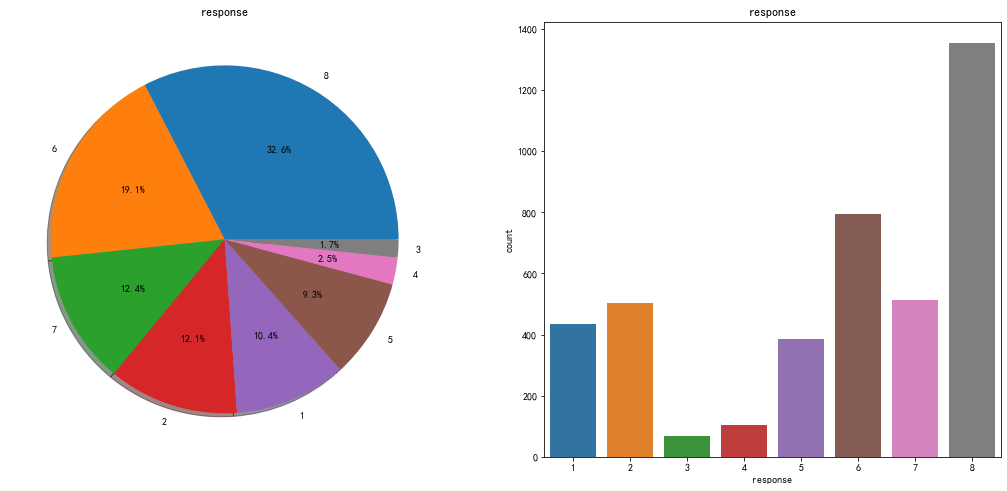

In [16]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('response')
ax[0].set_ylabel('')
sns.countplot('response',data=train,ax=ax[1])
ax[1].set_title('response')
plt.show()

**第八类的数据量最大，最少1.7%，与最多的19.1%相差10倍**
**数据存在极大的不平衡问题**

### 处理addr家庭住址

In [17]:
#将addr里省份单独拎出来，生成新特征province,并删除addr字段

#训练集
province = []
for address in train["addr"]:
    province.append(address[:3])
#print(province)
train["province"] = province

#删除addr
train.drop("addr", axis=1, inplace=True)


#测试集
province = []
for address in test["addr"]:
    province.append(address[:3])
#print(province)
test["province"] = province

#删除addr
test.drop("addr", axis=1, inplace=True)

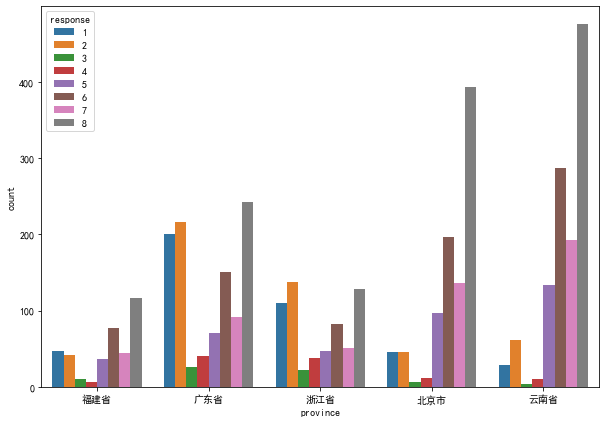

In [18]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'province', hue = 'response', data = train)

### 广东省与浙江省的满意度比较低

In [19]:
train.head()

,name,sex,id_card,mobile_number,email,product_info_1,product_info_2,product_info_3,product_info_4,product_info_5,...,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response,province
0,孙*,女,**************173X,1721258****,NaN,1,D4,26,0.743590,2,...,0,0,0,0,0,0,0,0,6,福建省
1,陆昌*,男,**************3850,1827906****,NaN,1,A8,10,0.076923,2,...,0,0,0,0,0,0,0,0,1,广东省
2,陈*,男,**************3750,1327455****,NaN,2,D4,26,0.487179,2,...,0,0,0,0,0,0,0,0,8,广东省
3,周凡*,女,**************1925,1523119****,NaN,1,D3,26,0.641026,2,...,0,0,0,0,0,0,0,0,6,广东省
4,李*,女,**************5522,1714197****,NaN,1,D2,26,0.076923,2,...,0,0,0,0,0,0,0,0,3,浙江省


### 删除无用的字段：name,email

In [20]:
#训练集
#删除name，email
train.drop("name", axis=1, inplace=True)
train.drop("email", axis=1, inplace=True)


#测试集
test.drop("name", axis=1, inplace=True)
test.drop("email", axis=1, inplace=True)

In [21]:
train.head()

,sex,id_card,mobile_number,product_info_1,product_info_2,product_info_3,product_info_4,product_info_5,product_info_6,product_info_7,...,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response,province
0,女,**************173X,1721258****,1,D4,26,0.743590,2,3,1,...,0,0,0,0,0,0,0,0,6,福建省
1,男,**************3850,1827906****,1,A8,10,0.076923,2,1,1,...,0,0,0,0,0,0,0,0,1,广东省
2,男,**************3750,1327455****,2,D4,26,0.487179,2,1,1,...,0,0,0,0,0,0,0,0,8,广东省
3,女,**************1925,1523119****,1,D3,26,0.641026,2,3,1,...,0,0,0,0,0,0,0,0,6,广东省
4,女,**************5522,1714197****,1,D2,26,0.076923,2,3,1,...,0,0,0,0,0,0,0,0,3,浙江省


### 性别一致性检查 + 编码

In [22]:
#训练集
sex = []
for s in train["id_card"]:
    if (int(s[-2])%2==0):
        sex.append(0)
    else:
        sex.append(1)
    
#print(sex)
train["sex"] = sex
train["sex"]

0       1
1       1
2       1
3       0
4       0
       ..
4152    0
4153    1
4154    1
4155    0
4156    1
Name: sex, Length: 4157, dtype: int64

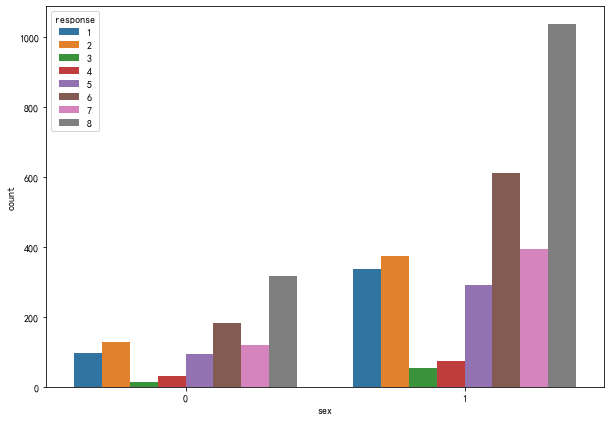

In [23]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'sex', hue = 'response', data = train)

### 探索特征的分布

数据分析师根据领域知识，对数据表中的特征进行数据探索。

* **Weight**： 客户的体重信息

In [24]:
#基本信息描述
train["wt"].describe(percentiles=[.8, .9, .95, .98, .999])

count    4157.000000
mean        0.294802
std         0.090277
min         0.100418
50%         0.288703
80%         0.361925
90%         0.414226
95%         0.456067
98%         0.518828
99.9%       0.679397
max         0.728033
Name: wt, dtype: float64

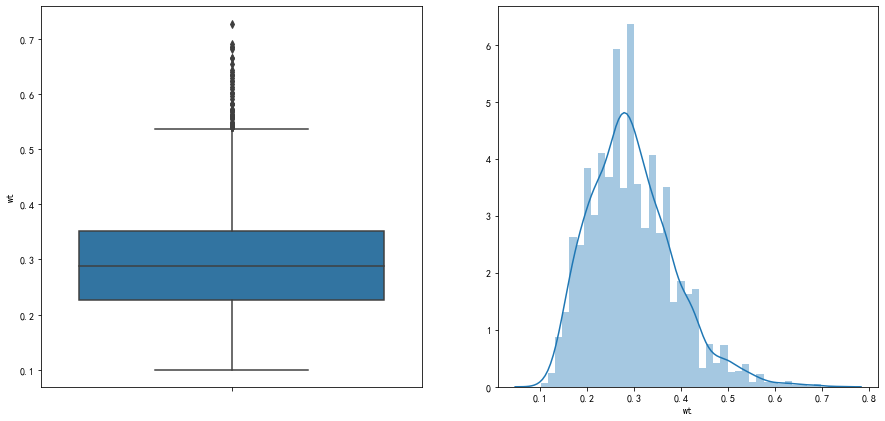

In [25]:
#箱状图与密度直方图
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x = 'wt', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['wt'],  ax=axes[1])

* **Height**：客户的身高信息

In [26]:
#基本信息描述
train["ht"].describe(percentiles=[.8, .9, .95, .98, .999])

count    4157.000000
mean        0.708881
std         0.074983
min         0.436364
50%         0.709091
80%         0.781818
90%         0.800000
95%         0.818182
98%         0.854545
99.9%       0.909091
max         0.963636
Name: ht, dtype: float64

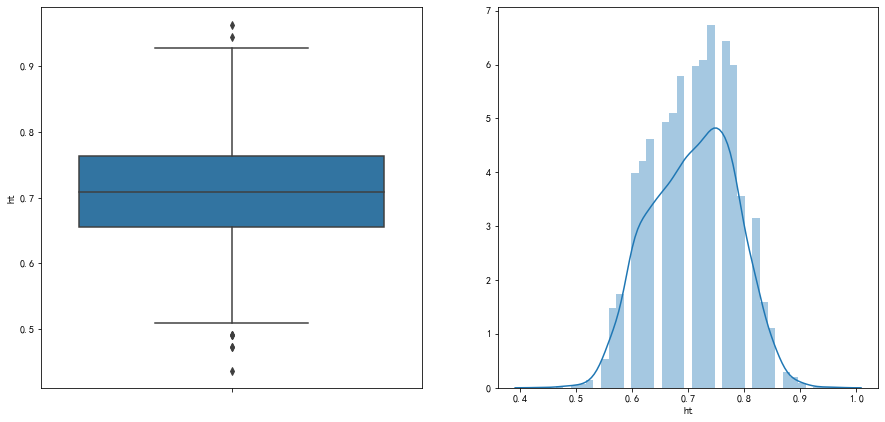

In [27]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x = 'ht', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['ht'],  ax=axes[1])

* **BMI**：客户的BMI信息

In [28]:
#基本信息描述
train["bmi"].describe(percentiles=[.8, .9, .95, .98, .999])

count    4157.000000
mean        0.471882
std         0.125129
min         0.182548
50%         0.452490
80%         0.561543
90%         0.638525
95%         0.713488
98%         0.801445
99.9%       1.000000
max         1.000000
Name: bmi, dtype: float64

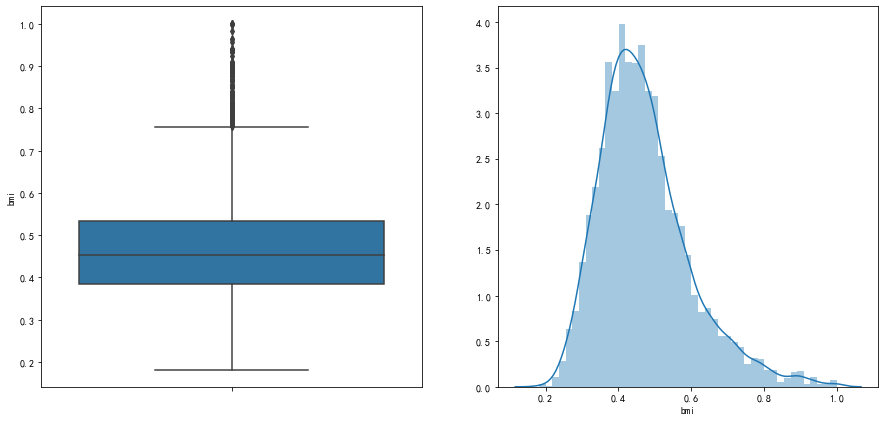

In [29]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x = 'bmi', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['bmi'],  ax=axes[1])

* **Age**：客户的年龄信息

In [30]:
#基本信息描述
train["ins_age"].describe(percentiles=[.8, .9, .95, .98, .999])

count    4157.000000
mean        0.404472
std         0.196949
min         0.000000
50%         0.402985
80%         0.597015
90%         0.671642
95%         0.716418
98%         0.761194
99.9%       0.863343
max         0.910448
Name: ins_age, dtype: float64

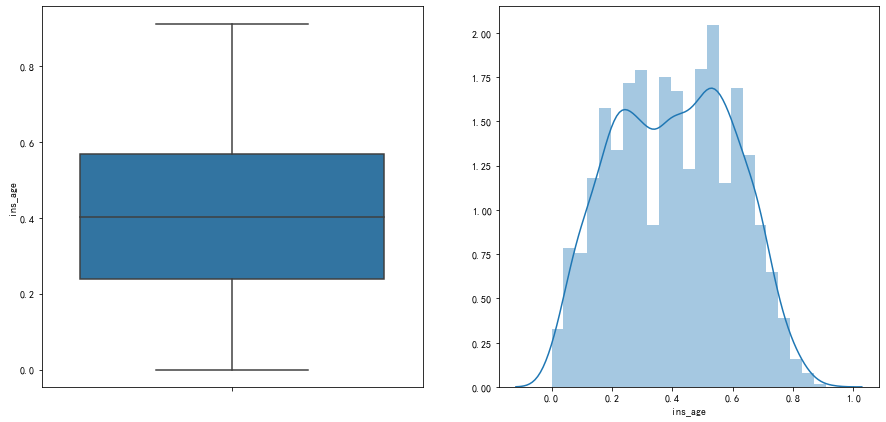

In [31]:
f,axes=plt.subplots(1,2,figsize=(15,7))
sns.boxplot(x = 'ins_age', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['ins_age'],ax=axes[1])

#### 结论
`1.对于前三个特征，从箱状图可以看出有异常值，但是这些数据是经过处理的，无法确定是异常值，不予处理`
`2.对于年龄特征，不存在异常值`

**根据BMI，AGE，HEIGHT和WEIGHT的值对它们进行离散化处理**

In [32]:
# BMI离散化处理
conditions = [
    (train['bmi'] <= train['bmi'].quantile(0.25)),
    (train['bmi'] > train['bmi'].quantile(0.25)) & (train['bmi'] <= train['bmi'].quantile(0.75)),
    (train['bmi'] > train['bmi'].quantile(0.75))]

choices = ['under_weight', 'average', 'overweight']

train['BMI_Wt'] = np.select(conditions, choices)

# 年龄离散化处理
conditions = [
    (train['ins_age'] <= train['ins_age'].quantile(0.25)),
    (train['ins_age'] > train['ins_age'].quantile(0.25)) & (train['ins_age'] <= train['ins_age'].quantile(0.75)),
    (train['ins_age'] > train['ins_age'].quantile(0.75))]

choices = ['young', 'average', 'old']
train['Old_Young'] = np.select(conditions, choices)

# 身份离散化处理
conditions = [
    (train['ht'] <= train['ht'].quantile(0.25)),
    (train['ht'] > train['ht'].quantile(0.25)) & (train['ht'] <= train['ht'].quantile(0.75)),
    (train['ht'] > train['ht'].quantile(0.75))]

choices = ['short', 'average', 'tall']

train['Short_Tall'] = np.select(conditions, choices)

# 体重离散化处理
conditions = [
    (train['wt'] <= train['wt'].quantile(0.25)),
    (train['wt'] > train['wt'].quantile(0.25)) & (train['wt'] <= train['wt'].quantile(0.75)),
    (train['wt'] > train['wt'].quantile(0.75))]

choices = ['thin', 'average', 'fat']

train['Thin_Fat'] = np.select(conditions, choices)

### 在其他特征的探索阶段，为了方便分析，将标签转化为二分类

**0-7作为1类， 8作为一类进行标签制作**

In [33]:
#制作标签函数
def new_target(row):
    if (row['response']<=7) & (row['response']>=0):
        val=0
    elif (row['response']==8):
        val=1
    else:
        val=-1
    return val

In [34]:
#保存一份原始数据集
new_data=train.copy()

In [35]:
#产生新的标签列
new_data['Final_Response']=new_data.apply(new_target,axis=1)

In [36]:
new_data['Final_Response'].value_counts()

0    2802
1    1355
Name: Final_Response, dtype: int64

Text(0.5, 1.0, 'Distribution of rows by response categories')

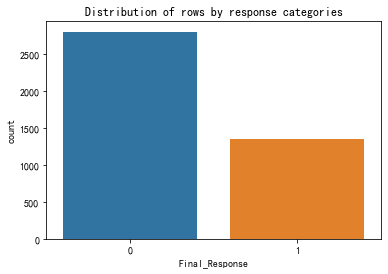

In [37]:
#查看新的标签分布
sns.countplot(x=new_data.Final_Response).set_title('Distribution of rows by response categories')

In [38]:
#删除旧的标签列
new_data.drop(['response'],axis=1,inplace=True)
train=new_data

In [39]:
del new_data

In [40]:
#重命名
train.rename(columns={'Final_Response':'response'},inplace=True)

### 查看新的特征在新的标签上的分布

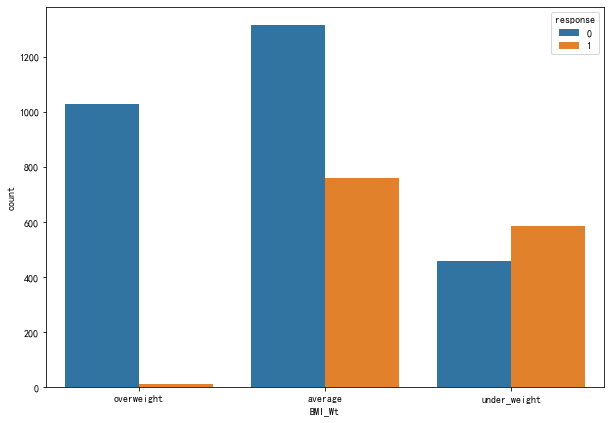

In [41]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'BMI_Wt', hue = 'response', data = train)

#### 结论：从此图可以看出，身体指数overweight的客户响应值为8的概率极小

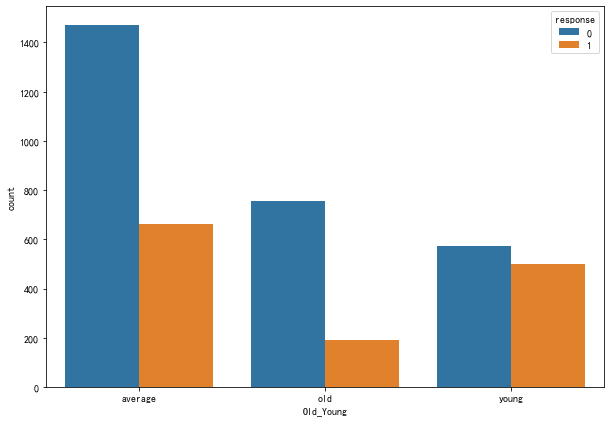

In [42]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'Old_Young', hue = 'response', data = train)

#### 结论：从上图可以看出，年长的客户响应值为8的概率较小

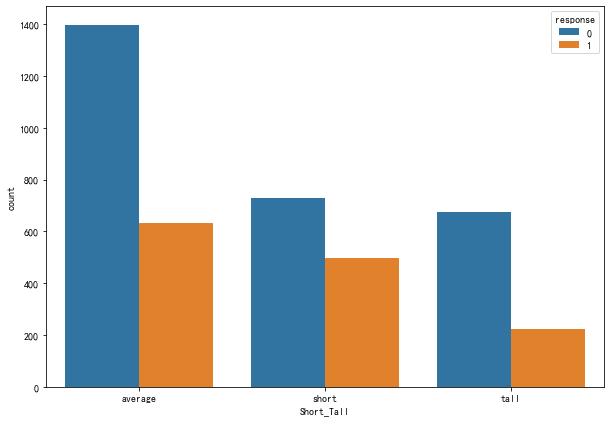

In [43]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'Short_Tall', hue = 'response', data = train)

#### 结论：从上图可以看出，身高对于客户意愿的影响较小

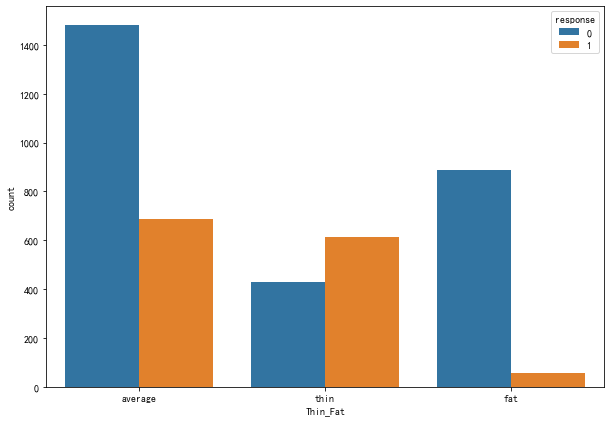

In [44]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'Thin_Fat', hue = 'response', data = train)

#### 结论：而经过以上的柱状图，过于肥胖的人群，意愿为8的概率极小

### 构建新的特征

数据分析师根据经验，将年长 或者 体重过重 或者 MBI指数底的客户定义为：属于危险指数较高的人群。

In [45]:
def new_target(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat'):
        val='extremely_risky'
    else:
        val='not_extremely_risky'
    return val

train['extreme_risk'] = train.apply(new_target,axis=1)

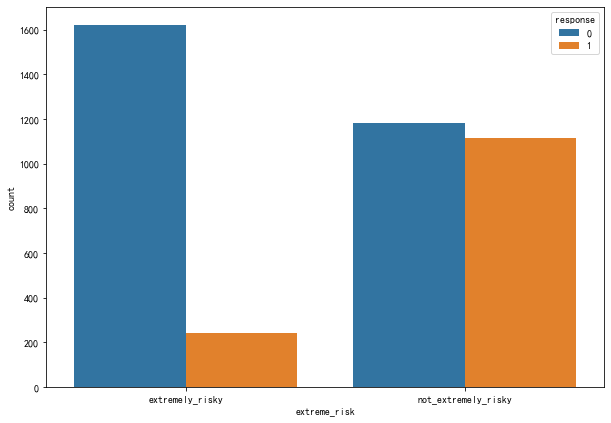

In [46]:
#查看新特征的目标值分布
plt.figure(figsize=(10,7))
sns.countplot(x = 'extreme_risk', hue = 'response', data = train)

**但是通过分析发现，风险值高的客户，响应值为8的概率极小**

In [47]:
def new_target(row):
    if (row['BMI_Wt']=='average') or (row['Old_Young']=='average')  or (row['Thin_Fat']=='average'):
        val='average'
    else:
        val='non_average'
    return val

train['average_risk'] = train.apply(new_target,axis=1)

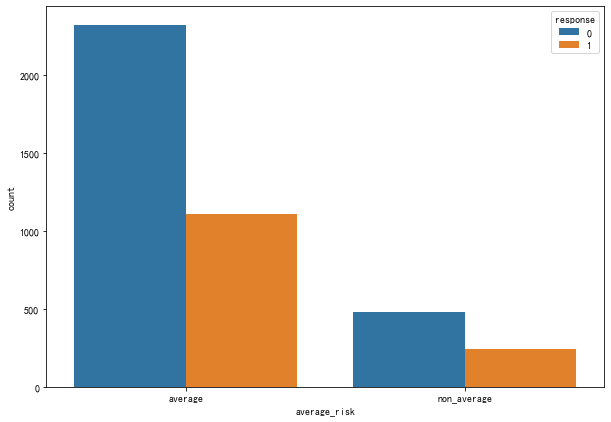

In [48]:
#查看新特征的目标值分布
plt.figure(figsize=(10,7))
sns.countplot(x = 'average_risk', hue = 'response', data = train)

**而处于中间范围的客户区别不大**

In [49]:
def new_target(row):
    if (row['BMI_Wt']=='under_weight') or (row['Old_Young']=='young')  or (row['Thin_Fat']=='thin'):
        val='low_end'
    else:
        val='non_low_end'
    return val

train['low_end_risk'] = train.apply(new_target,axis=1)

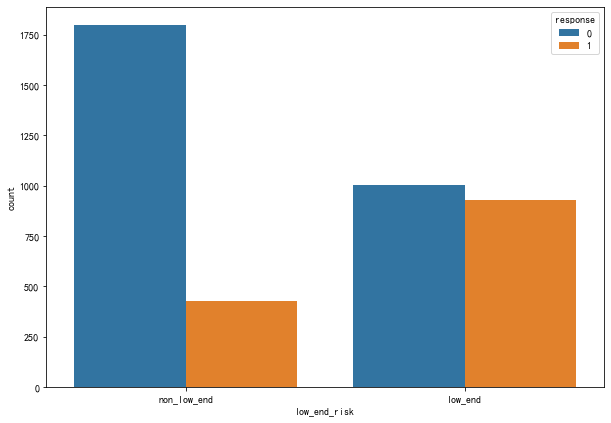

In [50]:
#查看新特征的目标值分布
plt.figure(figsize=(10,7))
sns.countplot(x = 'low_end_risk', hue = 'response', data = train)

#### 结论：在身体BMI指数低、太瘦、太年幼的客户，响应值为8的概率也比较小

###  对 object 特征`Product_Info_2`进行探索。

**数据集中唯一的`object`类型特征是`Product_Info_2`**，该特征共19个取值，字符串形式是**字母+数字**

In [51]:
#拆分Product_Info_2特征
train['Product_Info_2_char'] = train.product_info_2.str[0]
train['Product_Info_2_num'] = train.product_info_2.str[1]

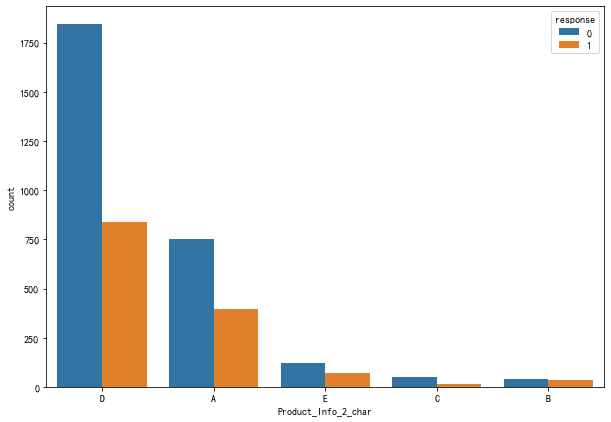

In [52]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'Product_Info_2_char', hue = 'response', data = train)

**char为`A`和`D`的客户响应为8的概率比较小**

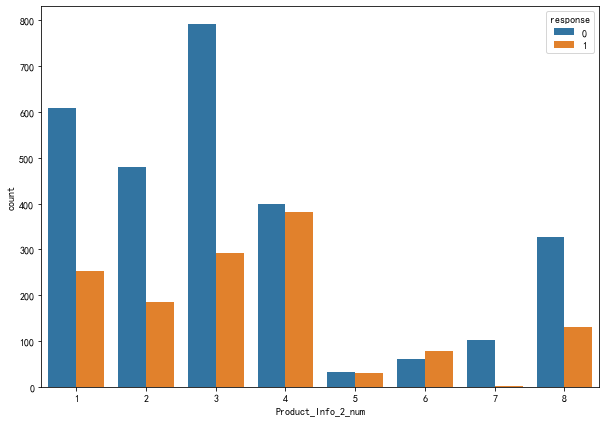

In [53]:
#查看num特征分布
plt.figure(figsize=(10,7))
sns.countplot(x = 'Product_Info_2_num', hue = 'response', data = train)

**`num` 为1，8，3，2，7的客户响应值为8的概率比较小**

### 构建新的特征

将`num`为 `1，8，3，2，7` 的客户 或者 char为`A`和`D`的客户视为**高风险**

In [54]:
def new_target4(row):
    if (row['Product_Info_2_num'] in list(['1','8','3','2','7'])) or  (row['Product_Info_2_char'] in list(['A', 'D'])):
        val='product2_risky'
    else:
        val='not_product2_risky'
    return val

train['product2_extreme_risk'] = train.apply(new_target4,axis=1)

### 探索医疗相关的特征

In [55]:
med_keyword_columns = train.columns[train.columns.str.startswith('medical_keyword_')]
train['Med_Keywords_Count'] = train[med_keyword_columns].sum(axis=1)   #求和（看病，吃药， ，，次数？？）
print(train['Med_Keywords_Count'].nunique())  # 11个取值，可作为新特征
train['Med_Keywords_Count'].unique()

12


array([ 3,  2,  4,  0,  1,  9,  5,  6,  7, 10,  8, 16])

In [56]:
med_keyword_columns = train.columns[train.columns.str.startswith('medical_keyword_')]
train['Med_Keywords_mean'] = train[med_keyword_columns].mean(axis=1)   #求均值（看病，吃药， ，，次数？？）
print(train['Med_Keywords_mean'].nunique())  # 11个取值，可作为新特征
train['Med_Keywords_mean'].unique()

12


array([0.0625    , 0.04166667, 0.08333333, 0.        , 0.02083333,
       0.1875    , 0.10416667, 0.125     , 0.14583333, 0.20833333,
       0.16666667, 0.33333333])

#### 结论：医疗系列特征的和与均值均只有12个取值，因此该和与均值可作为新的特征

### 探索家庭相关的特征

In [58]:
#求和
Family_Hist__keyword_columns = train.columns[train.columns.str.startswith('family_hist_')]
train['Family_Hist'] = train[Family_Hist__keyword_columns].sum(axis=1)
print(train['Family_Hist'].nunique())  # 2512个取值，没有区别，无参考价值
train['Family_Hist'].unique()

2585


array([3.62646823, 5.3253163 , 4.96748817, ..., 3.98672783, 4.42431609,
       5.13398055])

In [59]:
## 均值
Family_Hist__keyword_columns = train.columns[train.columns.str.startswith('family_hist_')]
train['Family_Hist'] = train[Family_Hist__keyword_columns].mean(axis=1)
print(train['Family_Hist'].nunique())  # 2512个取值，无参考价值
train['Family_Hist'].unique()

2585


array([0.72529365, 1.06506326, 0.99349763, ..., 0.79734557, 0.88486322,
       1.02679611])

## 根据领域知识构建新特征

数据分析师根据领域知识，将特征进行一定程度的组合形成新的特征，在数据分析中新的特征可能会帮助模型形成更好的预测效果。

次数数据分析师将**特征bmi**和**特征wt**相乘，得到新的特征。

In [60]:
train["bmi_wt"] =  train["bmi"]  * train["wt"]

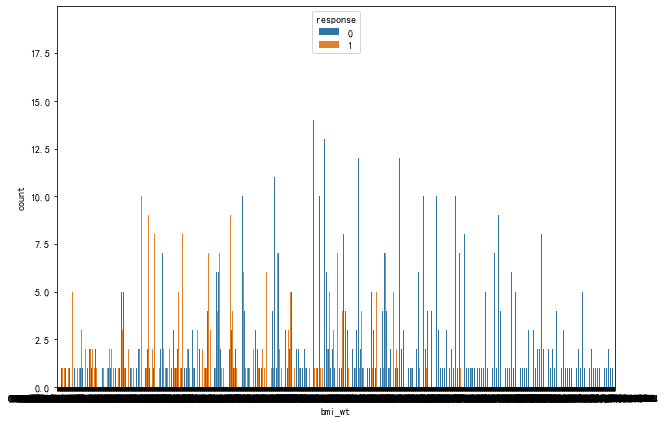

In [61]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'bmi_wt', hue = 'response', data = train)

### 结论：可以看到，标签在新特征分布上具有较为明显的不同，黄色的1标签分布更加靠左，而蓝色的0标签分布更加靠右

# 开始进行建模

## Version1

### 训练一个基础的 baseline 模型（Version 1）
`通常，数据分析师会根据简单的分析，建立一个baseline 模型。`

In [62]:
#计算Quadratic_Weighted_Kappa指标值
def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y, weights= 'quadratic')

#计算准确率Accuracy
def acc(y, yhat):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return accuracy_score(y, yhat)

In [63]:
# 导入数据集 保险数据集-训练
import wfio
_INPUT = '{"type":15,"uri":"awss32d9f105f22ab411298cdd6462cc2ee1d/sd_5629997fec4649668cd83bbd83aa03ba"}'
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
train = wfio.read_dataframe(_INPUT,as_spark = False)

# 导入数据集 保险数据集-测试-抽样
import wfio
_INPUT2 = '{"type":15,"uri":"awss3bbbfe5c8f0704f05b61aa304dde4ae74/sd_2de4c41af9b24ea3969f0a9537af7386"}'
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
test = wfio.read_dataframe(_INPUT2,as_spark = False)

# 全局变量
columns_to_drop = ['response']
xgb_num_rounds = 700
num_classes = 8

test_label = test["response"].copy()
test["response"] = -1000
# 将训练集与测试集拼接，并于统一特征处理
all_data = train.append(test)

#删除无用字段特征
all_data.drop(["empty_name", 'name', "sex", "id_card","mobile_number", "email", "addr"], axis = 1, inplace=True)

# 创建新特征 
# 特征编码
all_data['product_info_2'] = pd.factorize(all_data['product_info_2'])[0]

print('Eliminate missing values')    
# 空值填充-1
all_data.fillna(-1, inplace=True)

# 将label转为int值
all_data['response'] = all_data['response'].astype(int)

# 拆分数据集
train = all_data[all_data['response']>0].copy()
test = all_data[all_data['response']<1].copy()

# 转成xgb格式
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test_label.values)

Eliminate missing values


In [64]:
def get_params():
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 50
    params["subsample"] = 0.8
    params["colsample_bytree"] = 0.30
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())
    return plst
# 获取模型参数
plst = get_params()
evals_process = dict()   #存储训练过程中的指标，便于后面loss曲线图
model = xgb.train(plst, xgtrain, xgb_num_rounds,evals=[(xgtrain, 'train'),(xgtest,'test')],verbose_eval=50, evals_result = evals_process)#每50轮打印一次结果

[0]	train-rmse:5.41611	test-rmse:5.50816
[50]	train-rmse:1.89359	test-rmse:1.98103
[100]	train-rmse:1.70235	test-rmse:1.85859
[150]	train-rmse:1.60685	test-rmse:1.84381
[200]	train-rmse:1.52669	test-rmse:1.84188
[250]	train-rmse:1.45572	test-rmse:1.84564
[300]	train-rmse:1.39555	test-rmse:1.84856
[350]	train-rmse:1.33530	test-rmse:1.85471
[400]	train-rmse:1.28220	test-rmse:1.85868
[450]	train-rmse:1.23234	test-rmse:1.86279
[500]	train-rmse:1.18387	test-rmse:1.86856
[550]	train-rmse:1.14123	test-rmse:1.87395
[600]	train-rmse:1.10109	test-rmse:1.87925
[650]	train-rmse:1.05881	test-rmse:1.88375
[699]	train-rmse:1.02434	test-rmse:1.88657


In [65]:
#全量数据保存

##保存训练集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='train', norm_name='loss',norm_value=np.float(evals_process['train']["rmse"][i]),step=i)
    #print(evals_process['train']["rmse"][i])

##保存测试集集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='validation', norm_name='loss',norm_value=np.float(evals_process['test']["rmse"][i]),step=i)
    #print(evals_process['test']["rmse"][i]

norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm

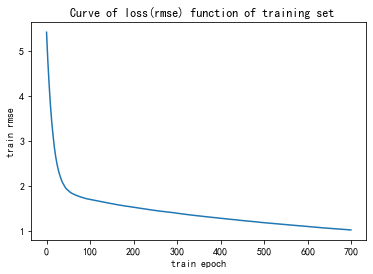

In [66]:
#绘制训练集的训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['train']["rmse"])
plt.ylabel('train rmse')
plt.xlabel('train epoch')
plt.title(" Curve of loss(rmse) function of training set")
plt.show()

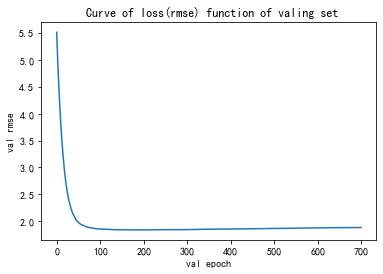

In [67]:
#绘制验证集在训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['test']["rmse"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('val rmse')
plt.xlabel('val epoch')
plt.title(" Curve of loss(rmse) function of valing set")
plt.show()

In [68]:
#打印Quadratic_Weighted_Kappa指标值
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train kappa score is:', eval_wrapper(train_preds, train['response']))
#print('Train accuracy score is:', acc(train["response"], train_preds))

test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
print('Test kappa score is:', eval_wrapper( test_preds, test_label))

Train kappa score is: 0.8877906668927967
Test kappa score is: 0.588265050423778


In [69]:
#保存测试集全量数据的指标值
base.save_norm(model_name='xgbregression', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper( test_preds, test_label)), operate_type='test')         

norm validate success,begin saving...
access token is None, skipping transforming.


### 结论：全量运行的baseline模型Quadratic_Weighted_Kappa为0.612
`1.数据分析师在完成了一些基本的数据预处理操作之后，执行了全量运行操作。`<p>
`2.至此全量运行结果为Version 1，这个模型将作为分析师的 baseline 模型。`<p>
`3.我们可以从全量运行记录中查看 Version 1 模型的运行时间等信息。`

* * *

* * *

## Version2

### 根据上面的探索结论，构建新特征，优化模型（Version 2）
`优化的方案包括：`<p>
`1.根据数据探索的情况，结合领域知识，将客户的BMI与体重相乘，形成新的特征"bmi_wt"， 将客户的BMI与年龄相乘，形成新的特征"bmi_age"`<p>
`2.通过体重、身高、BMI数据，对客户体型状况进行分类，将客户的身体风险进行划分，新增两个风险特征"extreme_risk"和"low_end_risk"。`<p>
`3.对Product_info2字段，进行分解，生成字母字段"Product_info2_char"和数字字段"Product_info2_num"，构成产品相关的两个特征`<p>
`4.对客户医疗相关的48个特征求均值和和，构建两个新特征`<p>
`5.针对该多级分类任务，使用凸优化函数，学习训练集预测的结果与真实值的偏移量，再将学习到的偏移量应用到测试集预测上，以此来优化预测结果`<p>

In [70]:
def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y, weights= 'quadratic')
    
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    #data[0] = data[1]是预测值， data[2]是真实标签值
    #sv是是类别编号sv = 0(1, 2, 3, 4, 5, 6, 7)
    #把预测值等于sv这一类的样本预测值取出来 + bin_offset偏移量 作为新的预测值
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

def new_target3(row):
    if (row['BMI_Wt']=='under_weight') or (row['Old_Young']=='young')  or (row['Thin_Fat']=='thin'):
        val='low_end'
    else:
        val='non_low_end'
    return val


def new_target1(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat'):
        val='extremely_risky'
    else:
        val='not_extremely_risky'
    return val

def acc(y, yhat):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return accuracy_score(y, yhat)

In [71]:
# 导入数据集 保险数据集-训练
 
import wfio
_INPUT = '{"type":15,"uri":"awss32d9f105f22ab411298cdd6462cc2ee1d/sd_5629997fec4649668cd83bbd83aa03ba"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
train = wfio.read_dataframe(_INPUT,as_spark = False)

# 导入数据集 保险数据集-测试-抽样
 
import wfio
_INPUT2 = '{"type":15,"uri":"awss3bbbfe5c8f0704f05b61aa304dde4ae74/sd_2de4c41af9b24ea3969f0a9537af7386"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
test = wfio.read_dataframe(_INPUT2,as_spark = False)

# 全局变量
columns_to_drop = ['response']
xgb_num_rounds = 700
num_classes = 8

test_label = test["response"].copy()
test["response"] = -1000
# 将训练集与测试集拼接，并于统一特征处理
all_data = train.append(test)

# 创建新特征 
# 特征编码
all_data['product_info_2'] = pd.factorize(all_data['product_info_2'])[0]

print('Eliminate missing values')    
# 空值填充-1
all_data.fillna(-1, inplace=True)

# 将label转为int值
all_data['response'] = all_data['response'].astype(int)

Eliminate missing values


In [72]:
# BMI离散化处理
conditions = [
    (all_data['bmi'] <= all_data['bmi'].quantile(0.25)),
    (all_data['bmi'] > all_data['bmi'].quantile(0.25)) & (all_data['bmi'] <= all_data['bmi'].quantile(0.75)),
    (all_data['bmi'] > all_data['bmi'].quantile(0.75))]

choices = ['under_weight', 'average', 'overweight']

all_data['BMI_Wt'] = np.select(conditions, choices)

# 年龄离散化处理
conditions = [
    (all_data['ins_age'] <= all_data['ins_age'].quantile(0.25)),
    (all_data['ins_age'] > all_data['ins_age'].quantile(0.25)) & (all_data['ins_age'] <= all_data['ins_age'].quantile(0.75)),
    (all_data['ins_age'] > all_data['ins_age'].quantile(0.75))]

choices = ['young', 'average', 'old']
all_data['Old_Young'] = np.select(conditions, choices)

# 身份离散化处理
conditions = [
    (all_data['ht'] <= all_data['ht'].quantile(0.25)),
    (all_data['ht'] > all_data['ht'].quantile(0.25)) & (all_data['ht'] <= all_data['ht'].quantile(0.75)),
    (all_data['ht'] > all_data['ht'].quantile(0.75))]

choices = ['short', 'average', 'tall']

all_data['Short_Tall'] = np.select(conditions, choices)

# 体重离散化处理
conditions = [
    (all_data['wt'] <= all_data['wt'].quantile(0.25)),
    (all_data['wt'] > all_data['wt'].quantile(0.25)) & (all_data['wt'] <= all_data['wt'].quantile(0.75)),
    (all_data['wt'] > all_data['wt'].quantile(0.75))]

choices = ['thin', 'average', 'fat']

all_data['Thin_Fat'] = np.select(conditions, choices)

In [73]:
##创建新特征
all_data['extreme_risk'] = all_data.apply(new_target1,axis=1)
#创建新特征
all_data['low_end_risk'] = all_data.apply(new_target3,axis=1)

#对新特征进行编码
all_data['BMI_Wt'] = pd.factorize(all_data['BMI_Wt'])[0]
all_data['Old_Young'] = pd.factorize(all_data['Old_Young'])[0]
all_data['Short_Tall'] = pd.factorize(all_data['Short_Tall'])[0]
all_data['Thin_Fat'] = pd.factorize(all_data['Thin_Fat'])[0]
all_data['extreme_risk'] = pd.factorize(all_data['extreme_risk'])[0]
all_data['low_end_risk'] = pd.factorize(all_data['low_end_risk'])[0]

#删除无用特征
all_data.drop(["BMI_Wt", "Short_Tall","Thin_Fat","Old_Young"], axis=1, inplace = True)
#删除无用字段特征
all_data.drop(["empty_name", 'name', "sex", "id_card","mobile_number", "email", "addr"], axis = 1, inplace=True)

In [74]:
# 拆分数据集
train = all_data[all_data['response']>0].copy()
test = all_data[all_data['response']<1].copy()

# 转成xgb格式
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test_label.values)

In [75]:
def get_params():
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 50
    params["subsample"] = 0.8
    params["colsample_bytree"] = 0.30
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())
    return plst



# 获取模型参数
plst = get_params()
evals_process = dict()   #存储训练过程中的指标，便于后面loss曲线图
model = xgb.train(plst, xgtrain, xgb_num_rounds,evals=[(xgtrain, 'train'),(xgtest,'test')],verbose_eval=50, evals_result = evals_process)
#每50轮打印一次结果

[0]	train-rmse:5.41272	test-rmse:5.50614
[50]	train-rmse:1.88673	test-rmse:1.98068
[100]	train-rmse:1.70135	test-rmse:1.86278
[150]	train-rmse:1.60744	test-rmse:1.84839
[200]	train-rmse:1.52960	test-rmse:1.85092
[250]	train-rmse:1.46642	test-rmse:1.85377
[300]	train-rmse:1.40322	test-rmse:1.85848
[350]	train-rmse:1.34545	test-rmse:1.86899
[400]	train-rmse:1.29196	test-rmse:1.87252
[450]	train-rmse:1.24036	test-rmse:1.87495
[500]	train-rmse:1.19109	test-rmse:1.88006
[550]	train-rmse:1.14968	test-rmse:1.88480
[600]	train-rmse:1.10705	test-rmse:1.89054
[650]	train-rmse:1.06717	test-rmse:1.89684
[699]	train-rmse:1.02984	test-rmse:1.89997


In [76]:
#全量数据保存

##保存训练集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='train', norm_name='loss',norm_value=np.float(evals_process['train']["rmse"][i]),step=i)
    #print(evals_process['train']["rmse"][i])

##保存测试集集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='validation', norm_name='loss',norm_value=np.float(evals_process['test']["rmse"][i]),step=i)
    #print(evals_process['test']["rmse"][i]

norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm

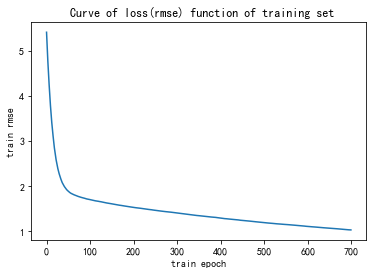

In [77]:
#绘制训练集的训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['train']["rmse"])
plt.ylabel('train rmse')
plt.xlabel('train epoch')
plt.title(" Curve of loss(rmse) function of training set")
plt.show()

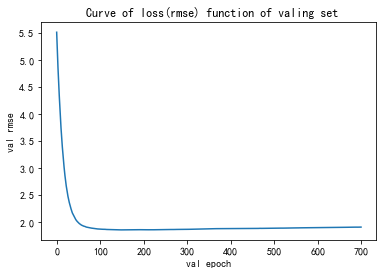

In [78]:
#绘制验证集在训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['test']["rmse"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('val rmse')
plt.xlabel('val epoch')
plt.title(" Curve of loss(rmse) function of valing set")
plt.show()

In [79]:
#凸优化学习最佳偏移量
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# 设置偏移量，并使用fmin_powell寻找最佳值
offsets = np.ones(num_classes) * -0.3
offset_train_preds = np.vstack((train_preds, train_preds, train['response'].values))
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(offset_train_preds, x, j)
    #def train_offset(x):
    #   -apply_offset(offset_train_preds, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# 将在训练集上的偏移量应用在测试集上
data = np.vstack((test_preds, test_preds, test['response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)
final_test_preds

Optimization terminated successfully.
         Current function value: -0.887791
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.890657
         Iterations: 2
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.903378
         Iterations: 2
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: -0.916433
         Iterations: 2
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: -0.916994
         Iterations: 2
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -0.917472
         Iterations: 2
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: -0.920653
         Iterations: 2
         Function evaluations: 63
Optimization terminated successful

array([3, 1, 7, ..., 1, 8, 6])

In [80]:
#全量数据指标保存
base.save_norm(model_name='xgbregression_offset', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper( final_test_preds, test_label)), operate_type='test')              

norm validate success,begin saving...
access token is None, skipping transforming.


In [81]:
print('Test kappa score is:', eval_wrapper( final_test_preds, test_label))

Test kappa score is: 0.6385574624269023


### 结论：优化后评估指标 "Quadratic_Weighted_Kappa" 达到了 0.657 
`1.通过全量运行即可形成优化后的Version2版本的模型`<p>
`2."Quadratic_Weighted_Kappa" 达到了 0.657, 取得了较好的水平。`<p>
`3.优化的结果较好，因此整个数据分析流程暂时结束，我们可以通过全量运行记录与其他模型进行对比。`<p>

### 申请带走最佳模型
`数据分析师将全量运行的模型与偏移量列表存入文件，并申报带走这两个运行结果，用于模型预测服务的部署。`

In [82]:
import pickle 

# 保存 offset 数组
pickle.dump(offsets, open("final_offset.list", "wb"))
# 保存 xgboost 模型
pickle.dump(model, open("xgboost.model", "wb"))

# 将 offset 数组上传至 oss 
wfio.upload_to_oss("final_offset.list", "./final_offset.list")
# 将 xgboost 模型上传至 oss 
wfio.upload_to_oss("xgboost.model", "./xgboost.model")

当前环境 [调试环境] 禁止上传到oss 文件系统 
当前环境 [调试环境] 禁止上传到oss 文件系统 
